# 1. Downloading code and initial EDA

In [48]:
# From CNN Daily Mail on Kaggle (composed of news articles with their summaries)
# https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail?resource=download

In [49]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Make runtimes go vroom vroom
from concurrent.futures import ProcessPoolExecutor

In [50]:
# For reproducbility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [51]:
data_filepath = 'data/cnn_dailymail/'

# Observations: Why is train-test-split like 280k-14k-13k ??
train_df = pd.read_csv(data_filepath + 'train.csv').drop(columns=['id'])
validation_df = pd.read_csv(data_filepath + 'validation.csv').drop(columns=['id'])
test_df = pd.read_csv(data_filepath + 'test.csv').drop(columns=['id'])

train_df.rename(columns={'article': 'transcript', 'highlights': 'summary'}, inplace=True)
validation_df.rename(columns={'article': 'transcript', 'highlights': 'summary'}, inplace=True)
test_df.rename(columns={'article': 'transcript', 'highlights': 'summary'}, inplace=True)

In [52]:
# Use 60k samples instead for train_df, scaling size of val and test sets as well
train_df = train_df.sample(n=60000, random_state=42).reset_index(drop=True)
validation_df = validation_df.sample(n=round(len(validation_df) / (280 / 60)), random_state=42).reset_index(drop=True)
test_df = test_df.sample(n=round(len(test_df) / (280 / 60)), random_state=42).reset_index(drop=True)

In [53]:
contractions_dict = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  60000 non-null  object
 1   summary     60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [55]:
# Commenting out for now because plan to use attention in LSTM
# Stopwords
# stop_words = set(stopwords.words('english'))

def clean_text(value):
    if isinstance(value, str):
        # Remove ('s)
        value = re.sub(r"'s", '', value)
        # Contractions expansion
        for contraction, expansion in contractions_dict.items():
            value = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, value, flags=re.IGNORECASE)
        # Remove all punctuation and special characters
        value = re.sub(r'[^\w\s]', '', value)
        # Tokenize, remove short words
        tokens = [word for word in word_tokenize(value.lower()) if len(word) > 2]
        return ' '.join(tokens)
    return value

# Function to process a chunk of data
def process_column(column):
    return column.apply(clean_text)

# Main cleaning function
def clean_data(data):
    num_workers = 16 
    
    # Parallelize 'transcript' cleaning
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        transcript_chunks = list(tqdm(
            executor.map(process_column, np.array_split(data['transcript'], num_workers)),
            total=num_workers,
            desc="Cleaning 'transcript'"
        ))
    data['transcript_cleaned'] = pd.concat(transcript_chunks, ignore_index=True)

    # Parallelize 'summary' cleaning
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        summary_chunks = list(tqdm(
            executor.map(process_column, np.array_split(data['summary'], num_workers)),
            total=num_workers,
            desc="Cleaning 'summary'"
        ))
    data['summary_cleaned'] = pd.concat(summary_chunks, ignore_index=True)

    # Drop rows where cleaned columns are null or empty
    data = data.dropna(subset=['summary_cleaned', 'transcript_cleaned'])
    data = data[
        ~data['summary_cleaned'].str.strip().eq('') &
        ~data['transcript_cleaned'].str.strip().eq('')
    ]

    # Retain only cleaned columns
    data = data[['transcript_cleaned', 'summary_cleaned']].rename(
        columns={'transcript_cleaned': 'transcript', 'summary_cleaned': 'summary'}
    )
    return data

In [56]:
train_df = clean_data(train_df)
validation_df = clean_data(validation_df)
test_df = clean_data(test_df)

/home/bubbles/miniconda3/envs/lstm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Cleaning 'transcript': 100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]
/home/bubbles/miniconda3/envs/lstm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Cleaning 'summary': 100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.82it/s]
/home/bubbles/miniconda3/envs/lstm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
 

In [57]:
# Add START and END tokens to summaries
train_df['summary'] = train_df['summary'].apply(lambda x: '<sos> ' + x + ' <eos>')
validation_df['summary'] = validation_df['summary'].apply(lambda x: '<sos> ' + x + ' <eos>')
test_df['summary'] = test_df['summary'].apply(lambda x: '<sos> ' + x + ' <eos>')

In [58]:
# train_df.iloc[42]['summary']

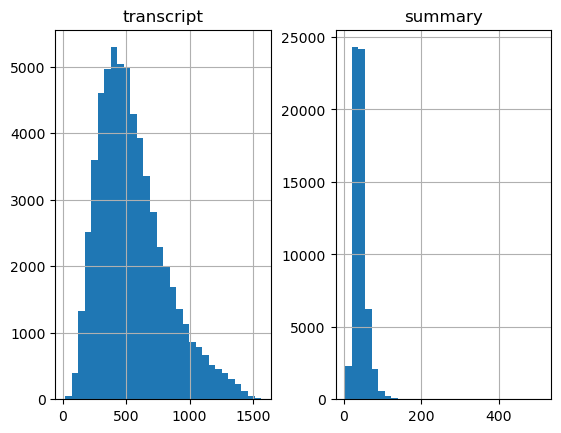

In [59]:
# EDA on sentence length for helping us choose max seq length when adding padding
transcript_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['transcript']:
      transcript_word_count.append(len(i.split()))

for i in train_df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'transcript':transcript_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [60]:
# Based on this let's choose max seq lengths that capture most of the distribution in the graphs above
max_len_summary = 100
max_len_transcript = 1000
vocab_size = 20_000

# 2. Time to make tokenizers woohoo

In [61]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

class Tokenizer:
    def __init__(self, num_words=None, oov_token="<unk>"):
        self.word_index = {"<pad>": 0, oov_token: 1}
        self.index_word = {0: "<pad>", 1: oov_token}
        self.num_words = num_words
        self.oov_token = oov_token

    def fit_on_texts(self, texts):
        word_counts = Counter(word for text in texts for word in text.split())
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        for idx, (word, _) in enumerate(sorted_vocab, start=2):
            if self.num_words and idx >= self.num_words:
                break
            self.word_index[word] = idx
            self.index_word[idx] = word

    def texts_to_sequences(self, texts):
        return [
            [self.word_index.get(word, self.word_index[self.oov_token]) for word in text.split()]
            for text in texts
        ]

def pad_sequences(seqs, maxlen, padding_value=0):
    padded_seqs = []
    for seq in seqs:
        if len(seq) > maxlen:
            seq = seq[:maxlen]
        padded_seqs.append(torch.tensor(seq + [padding_value] * (maxlen - len(seq))))
    return torch.stack(padded_seqs)

def process_data(df, max_len_transcript, max_len_summary, x_tokenizer, y_tokenizer):
    """
    Tokenize and pad sequences for both transcripts and summaries.
    Args:
        df: DataFrame containing 'transcript' and 'summary'.
        max_len_transcript: Maximum length for transcript sequences.
        max_len_summary: Maximum length for summary sequences.
        x_tokenizer: Tokenizer for transcripts.
        y_tokenizer: Tokenizer for summaries.
    Returns:
        x_padded: Padded sequences for transcripts.
        y_padded: Padded sequences for summaries.
    """
    # Tokenize and pad transcripts
    x_seq = x_tokenizer.texts_to_sequences(df['transcript'])
    x_padded = pad_sequences(x_seq, max_len_transcript)

    # Tokenize and pad summaries
    y_seq = y_tokenizer.texts_to_sequences(df['summary'])
    y_padded = pad_sequences(y_seq, max_len_summary)
    
    return x_padded, y_padded

In [62]:
x_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
y_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")

# Fit tokenizers on training set
x_tokenizer.fit_on_texts(train_df['transcript'])
y_tokenizer.fit_on_texts(train_df['summary'])

# Process data
x_train_padded, y_train_padded = process_data(train_df, max_len_transcript, max_len_summary, x_tokenizer, y_tokenizer)
x_val_padded, y_val_padded = process_data(validation_df, max_len_transcript, max_len_summary, x_tokenizer, y_tokenizer)
x_test_padded, y_test_padded = process_data(test_df, max_len_transcript, max_len_summary, x_tokenizer, y_tokenizer)

# Log processed data shapes
print(f"Training Data: X={x_train_padded.shape}, Y={y_train_padded.shape}")
print(f"Validation Data: X={x_val_padded.shape}, Y={y_val_padded.shape}")
print(f"Test Data: X={x_test_padded.shape}, Y={y_test_padded.shape}")

Exception ignored in: Traceback (most recent call last):
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/home/bubbles/miniconda3/envs/lstm/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/bubbles/m

Training Data: X=torch.Size([60000, 1000]), Y=torch.Size([60000, 100])
Validation Data: X=torch.Size([2865, 1000]), Y=torch.Size([2865, 100])
Test Data: X=torch.Size([2462, 1000]), Y=torch.Size([2462, 100])


# 3. Actually (finally) building the LSTM

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

## Architecture and hyperparams

In [64]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_layers, dropout, pretrained_embeddings):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)  # Fine-tune embeddings
        self.lstm = nn.LSTM(
            embed_dim, 
            hidden_dim, 
            num_layers, 
            dropout=dropout, 
            batch_first=True, 
            bidirectional=True 
        )
        self.hidden_proj = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cell_proj = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        # Combine bidirectional outputs for compatibility with decoder
        hidden = torch.tanh(self.hidden_proj(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))) 
        cell = torch.tanh(self.cell_proj(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1))) 

        return hidden.unsqueeze(0), cell.unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_layers, dropout, pretrained_embeddings, output_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)  # Fine-tune embeddings
        self.lstm = nn.LSTM(
            embed_dim, 
            hidden_dim, 
            num_layers, 
            dropout=dropout, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)  # Final fully connected layer for predictions
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        # Add a sequence dimension (batch_size -> batch_size, 1)
        x = x.unsqueeze(1)
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))  # Remove seq dim: (batch_size, output_dim)
        return predictions, hidden, cell


In [65]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass for Seq2Seq model.
        
        Args:
            src: Source sequence (input) tensor of shape (batch_size, src_len).
            trg: Target sequence (output) tensor of shape (batch_size, trg_len).
            teacher_forcing_ratio: Probability of using teacher forcing.
        
        Returns:
            outputs: Tensor of shape (batch_size, trg_len, trg_vocab_size).
        """
        trg_len = trg.shape[1]
        batch_size = trg.shape[0]
        trg_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input_token = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t, :] = output 

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = trg[:, t] if teacher_force else output.argmax(1)
        return outputs


## Setup and Hyperparameters

In [66]:
# Get pretrained embeddings
import gensim.downloader as api
import numpy as np
import torch

def load_pretrained_embeddings(word_index, embedding_dim=300, embedding_type='glove-wiki-gigaword-300'):
    """
    Load pretrained embeddings using Gensim and create an embedding matrix.

    Args:
        word_index: Vocabulary dictionary (word -> index).
        embedding_dim: Dimension of word vectors.
        embedding_type: Type of pretrained embeddings to load ('glove-wiki-gigaword-300', 'fasttext-wiki-news-subwords-300', etc.).

    Returns:
        embedding_matrix: A PyTorch tensor with pretrained embeddings.
    """
    print(f"Loading {embedding_type} embeddings...")
    embeddings_model = api.load(embedding_type)
    print("Embeddings loaded successfully.")

    # Initialize embedding matrix
    vocab_size = len(word_index) + 1  # +1 for padding token
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in word_index.items():
        if word in embeddings_model:
            embedding_matrix[idx] = embeddings_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random init for OOV words

    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 300 
x_pretrained_embeddings = load_pretrained_embeddings(x_tokenizer.word_index, embedding_dim, embedding_type='glove-wiki-gigaword-300')
y_pretrained_embeddings = load_pretrained_embeddings(y_tokenizer.word_index, embedding_dim, embedding_type='glove-wiki-gigaword-300')


Loading glove-wiki-gigaword-300 embeddings...
Embeddings loaded successfully.
Loading glove-wiki-gigaword-300 embeddings...
Embeddings loaded successfully.


In [75]:
hidden_dim = 512
embedding_dim_x = x_pretrained_embeddings.size(1)
embedding_dim_y = y_pretrained_embeddings.size(1)
vocab_size_x = len(x_tokenizer.word_index) + 1 
vocab_size_y = len(y_tokenizer.word_index) + 1
num_layers = 1
dropout_rate = 0.5
learning_rate = 1e-3 
embedding_lr = 1e-4
num_epochs = 30
batch_size = 128 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    embed_dim=embedding_dim_x, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers, 
    dropout=dropout_rate, 
    pretrained_embeddings=x_pretrained_embeddings
)

decoder = Decoder(
    embed_dim=embedding_dim_y, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers, 
    dropout=dropout_rate, 
    pretrained_embeddings=y_pretrained_embeddings,
    output_dim=vocab_size_y
)

model = Seq2Seq(encoder, decoder, device, pad_idx=0).to(device)

# Set up optimizer with differential learning rates
optimizer = torch.optim.Adam([
    {'params': encoder.embedding.parameters(), 'lr': embedding_lr},
    {'params': encoder.lstm.parameters()},
    {'params': decoder.embedding.parameters(), 'lr': embedding_lr},
    {'params': decoder.lstm.parameters()},
    {'params': decoder.fc.parameters()}
], lr=learning_rate)

criterion = nn.CrossEntropyLoss(ignore_index=0)

## Dataset and Dataloader Init

In [76]:
from torch.utils.data import Subset

def get_subset(dataset, fraction=0.2):
    subset_size = int(len(dataset) * fraction)
    subset_indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, subset_indices)

In [77]:
y_train_padded = torch.tensor(y_train_padded, dtype=torch.long).pin_memory()
x_val_padded = torch.tensor(x_val_padded, dtype=torch.long).pin_memory()
y_val_padded = torch.tensor(y_val_padded, dtype=torch.long).pin_memory()
x_test_padded = torch.tensor(x_test_padded, dtype=torch.long).pin_memory()
y_test_padded = torch.tensor(y_test_padded, dtype=torch.long).pin_memory()

train_dataset = TensorDataset(x_train_padded, y_train_padded)
val_dataset = TensorDataset(x_val_padded, y_val_padded)
test_dataset = TensorDataset(x_test_padded, y_test_padded)

# Apply subsampling to the training dataset
fraction = 0.2
train_subset = get_subset(train_dataset, fraction=fraction)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=24,
    prefetch_factor=8,
    persistent_workers=True
)

print(f"Subsampled Train DataLoader: {len(train_loader)} batches of size {batch_size}")

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=24, 
    prefetch_factor=8, 
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=24, 
    prefetch_factor=8, 
    persistent_workers=True
)

print(f"Validation DataLoader: {len(val_loader)} batches of size {batch_size}")
print(f"Test DataLoader: {len(test_loader)} batches of size {batch_size}")

Subsampled Train DataLoader: 94 batches of size 128
Validation DataLoader: 23 batches of size 128
Test DataLoader: 20 batches of size 128


/tmp/ipykernel_3763/143856901.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_padded = torch.tensor(x_train_padded, dtype=torch.long).pin_memory()
/tmp/ipykernel_3763/143856901.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_padded = torch.tensor(y_train_padded, dtype=torch.long).pin_memory()
/tmp/ipykernel_3763/143856901.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_padded = torch.tensor(x_val_padded, dtype=torch.long).pin_memory()
/tmp/ipykernel_3763/143856901.py:5: UserWarning: To copy construct from

## Training

In [78]:
import random
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

def calculate_accuracy(predictions, targets, pad_idx=0):
    pred_tokens = predictions.argmax(-1)
    correct = (pred_tokens == targets).float()
    mask = (targets != pad_idx).float()  # Ignore <pad> tokens
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

def masked_loss(output, target, criterion, pad_idx=0):
    mask = target != pad_idx
    output = output.view(-1, output.size(-1))
    target = target.view(-1)
    loss = criterion(output, target)
    loss = (loss * mask.view(-1)).sum() / mask.sum()
    return loss

def train_one_epoch(model, train_loader, optimizer, criterion, scaler, accumulation_steps=1, teacher_forcing_ratio=0.5):
    model.train()
    train_loss = 0
    train_accuracy = 0
    optimizer.zero_grad()

    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for step, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)

            with torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
                output = model(X_batch, y_batch, teacher_forcing_ratio=teacher_forcing_ratio)
                loss = masked_loss(output, y_batch, criterion) / accumulation_steps

            scaler.scale(loss).backward()

            # Update weights after accumulation_steps
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            accuracy = calculate_accuracy(output, y_batch)
            train_loss += loss.item() * accumulation_steps
            train_accuracy += accuracy

            pbar.set_postfix({"Loss": loss.item() * accumulation_steps, "Accuracy": accuracy})
            pbar.update(1)

    avg_loss = train_loss / len(train_loader)
    avg_accuracy = train_accuracy / len(train_loader)
    return avg_loss, avg_accuracy

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)

                with torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
                    output = model(X_batch, y_batch, teacher_forcing_ratio=0)  # No teacher forcing during validation
                    loss = masked_loss(output, y_batch, criterion)

                accuracy = calculate_accuracy(output, y_batch)
                val_loss += loss.item()
                val_accuracy += accuracy

                pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy})
                pbar.update(1)

    avg_loss = val_loss / len(val_loader)
    avg_accuracy = val_accuracy / len(val_loader)
    return avg_loss, avg_accuracy

def train(model, train_dataset, val_loader, optimizer, criterion, fraction=0.2):
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Create a new subset of the training dataset for this epoch
        train_subset = get_subset(train_dataset, fraction=fraction)  # Use train_dataset, not train_loader
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=24,
            prefetch_factor=8,
            persistent_workers=True
        )

        teacher_forcing_ratio = max(0.5 - epoch * 0.02, 0.1)  # Reduce teacher forcing over epochs
        train_loss, train_accuracy = train_one_epoch(
            model, train_loader, optimizer, criterion, scaler, accumulation_steps=2, teacher_forcing_ratio=teacher_forcing_ratio
        )

        torch.cuda.synchronize()  # Ensure training computations complete

        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_accuracy = 0

    print("Evaluating on test data...")
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)

                with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    output = model(X_batch, y_batch, teacher_forcing_ratio=0)  # No teacher forcing during evaluation
                    loss = masked_loss(output, y_batch, criterion)

                accuracy = calculate_accuracy(output, y_batch)
                test_loss += loss.item()
                test_accuracy += accuracy

                pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy})
                pbar.update(1)

    avg_loss = test_loss / len(test_loader)
    avg_accuracy = test_accuracy / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}")


In [79]:
# torch.cuda.empty_cache()

In [ ]:
train(model, train_dataset, val_loader, optimizer, criterion)

/tmp/ipykernel_3763/2232307417.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.80batch/s, Loss=7.54, Accuracy=0.0656]


Train Loss: 8.6153, Train Accuracy: 0.0518
Validation Loss: 7.6692, Validation Accuracy: 0.0596
Epoch 2/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.49batch/s, Loss=7.44, Accuracy=0.0656]


Train Loss: 7.7021, Train Accuracy: 0.0561
Validation Loss: 7.5478, Validation Accuracy: 0.0596
Epoch 3/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.45batch/s, Loss=7.42, Accuracy=0.0652]


Train Loss: 7.6393, Train Accuracy: 0.0566
Validation Loss: 7.5284, Validation Accuracy: 0.0597
Epoch 4/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.46batch/s, Loss=7.41, Accuracy=0.0665]


Train Loss: 7.6230, Train Accuracy: 0.0598
Validation Loss: 7.5297, Validation Accuracy: 0.0600
Epoch 5/30


Validation: 100%|██████████████████████████████████████████████████████████| 23/23 [00:07<00:00,  3.16batch/s, Loss=7.4, Accuracy=0.0691]


Train Loss: 7.6177, Train Accuracy: 0.0601
Validation Loss: 7.5058, Validation Accuracy: 0.0619
Epoch 6/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.34batch/s, Loss=7.39, Accuracy=0.0638]


Train Loss: 7.6073, Train Accuracy: 0.0618
Validation Loss: 7.4981, Validation Accuracy: 0.0600
Epoch 7/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.49batch/s, Loss=7.39, Accuracy=0.0686]


Train Loss: 7.5941, Train Accuracy: 0.0619
Validation Loss: 7.4914, Validation Accuracy: 0.0613
Epoch 8/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.44batch/s, Loss=7.39, Accuracy=0.0638]


Train Loss: 7.5946, Train Accuracy: 0.0617
Validation Loss: 7.4875, Validation Accuracy: 0.0617
Epoch 9/30


Validation: 100%|██████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.47batch/s, Loss=7.4, Accuracy=0.0678]


Train Loss: 7.5904, Train Accuracy: 0.0616
Validation Loss: 7.4961, Validation Accuracy: 0.0605
Epoch 10/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.47batch/s, Loss=7.39, Accuracy=0.0656]


Train Loss: 7.5664, Train Accuracy: 0.0627
Validation Loss: 7.4882, Validation Accuracy: 0.0606
Epoch 11/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.50batch/s, Loss=7.38, Accuracy=0.0643]


Train Loss: 7.5638, Train Accuracy: 0.0621
Validation Loss: 7.4873, Validation Accuracy: 0.0610
Epoch 12/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.48batch/s, Loss=7.39, Accuracy=0.0638]


Train Loss: 7.5518, Train Accuracy: 0.0626
Validation Loss: 7.4878, Validation Accuracy: 0.0616
Epoch 13/30


Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.51batch/s, Loss=7.37, Accuracy=0.0647]


Train Loss: 7.5540, Train Accuracy: 0.0621
Validation Loss: 7.4854, Validation Accuracy: 0.0614
Epoch 14/30


Validation: 100%|██████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.49batch/s, Loss=7.37, Accuracy=0.066]


Train Loss: 7.5383, Train Accuracy: 0.0621
Validation Loss: 7.4793, Validation Accuracy: 0.0604
Epoch 15/30


Training: 100%|████████████████████████████████████████████████████████████| 94/94 [01:03<00:00,  1.49batch/s, Loss=7.55, Accuracy=0.063]
Validation: 100%|█| 23/23 [00:06<00:00,  3.51batch/s, Loss=7.39, Acc


Train Loss: 7.5457, Train Accuracy: 0.0624
Validation Loss: 7.4816, Validation Accuracy: 0.0604
Epoch 16/30


Training: 100%|█| 94/94 [01:03<00:00,  1.49batch/s, Loss=7.51, Accur
Validation: 100%|█████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.32batch/s, Loss=7.38, Accuracy=0.0673]


Train Loss: 7.5372, Train Accuracy: 0.0614
Validation Loss: 7.4826, Validation Accuracy: 0.0608
Epoch 17/30


Training:  11%|██████▎                                                    | 10/94 [00:08<00:57,  1.46batch/s, Loss=7.52, Accuracy=0.0685]